Sander Coscia, Jamie Rapal
CS 548
Project 4
11/22/2024

Here Contains the Hierarchical models, DBSCAN models, and LIME analysis. It also contains citations for ChatGPT.

In [2]:
import pandas as pd

data = pd.read_excel('/Users/sandersander/Documents/CS 548/Online Retail.xlsx')

print(data.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [3]:
#Check for data Info
print(data.isnull().sum())

print(data.dtypes)

print(data.describe())

print(data.duplicated().sum())


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object
            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000 

In [4]:
# Drop rows with missing CustomerID
data = data.dropna(subset=['CustomerID'])

# Drop Description column
data = data.drop(columns=['Description'])
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

data['InvoiceYear'] = data['InvoiceDate'].dt.year
data['InvoiceMonth'] = data['InvoiceDate'].dt.month
data['InvoiceDay'] = data['InvoiceDate'].dt.day
data['InvoiceHour'] = data['InvoiceDate'].dt.hour
print(data.head())

  InvoiceNo StockCode  Quantity         InvoiceDate  UnitPrice  CustomerID  \
0    536365    85123A         6 2010-12-01 08:26:00       2.55     17850.0   
1    536365     71053         6 2010-12-01 08:26:00       3.39     17850.0   
2    536365    84406B         8 2010-12-01 08:26:00       2.75     17850.0   
3    536365    84029G         6 2010-12-01 08:26:00       3.39     17850.0   
4    536365    84029E         6 2010-12-01 08:26:00       3.39     17850.0   

          Country  TotalPrice  InvoiceYear  InvoiceMonth  InvoiceDay  \
0  United Kingdom       15.30         2010            12           1   
1  United Kingdom       20.34         2010            12           1   
2  United Kingdom       22.00         2010            12           1   
3  United Kingdom       20.34         2010            12           1   
4  United Kingdom       20.34         2010            12           1   

   InvoiceHour  
0            8  
1            8  
2            8  
3            8  
4            

DBSCAN Models

Davies-Bouldin Score: 2.6890505859038605
Silhouette Score: 0.8807999009556221
Cluster Sizes: {-1: 133, 0: 19815, 1: 7, 2: 7, 3: 8, 4: 6, 5: 6, 6: 6, 7: 7, 8: 5}


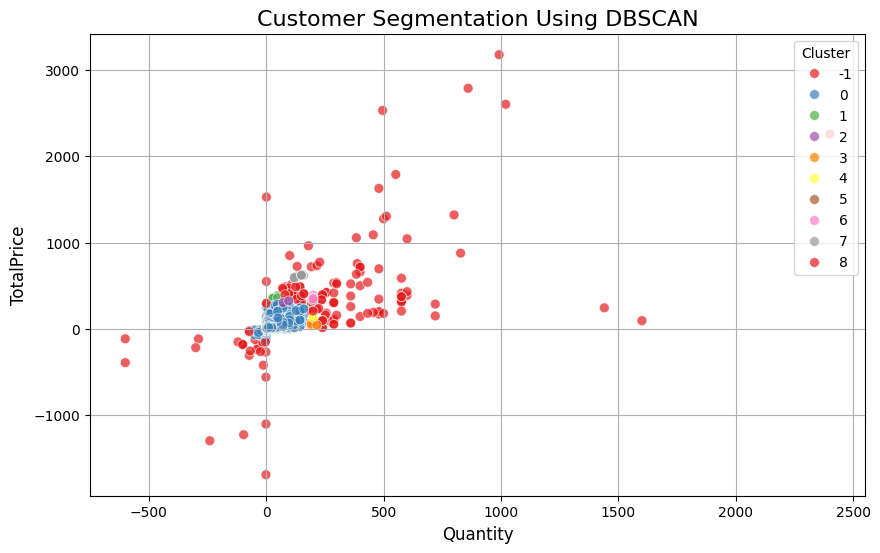

In [34]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Subsample 20,000 rows because kernel kept crashing
sample_data = data.sample(n=20000, random_state=42)

# Calculate TotalPrice (Quantity * UnitPrice)
sample_data['TotalPrice'] = sample_data['Quantity'] * sample_data['UnitPrice']

features = sample_data[['Quantity', 'TotalPrice']]

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Create and fit the DBSCAN model
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels = dbscan.fit_predict(scaled_features)

# Davies-Bouldin score
db_score = davies_bouldin_score(scaled_features, labels)

# Silhouette Score
sil_score = silhouette_score(scaled_features, labels)

# Step 8: Get cluster sizes
unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))

# Print the results
print(f"Davies-Bouldin Score: {db_score}")
print(f"Silhouette Score: {sil_score}")
print(f"Cluster Sizes: {cluster_sizes}")

# Add cluster labels to the data for plotting
sample_data['Cluster'] = labels

# Plot the data points with cluster labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_data, x='Quantity', y='TotalPrice', hue='Cluster', palette='Set1', s=50, alpha=0.7)

plt.title('Customer Segmentation Using DBSCAN', fontsize=16)
plt.xlabel('Quantity', fontsize=12)
plt.ylabel('TotalPrice', fontsize=12)
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)

plt.show()



Elbow Method for Epsilon Hyperparameter Tuning

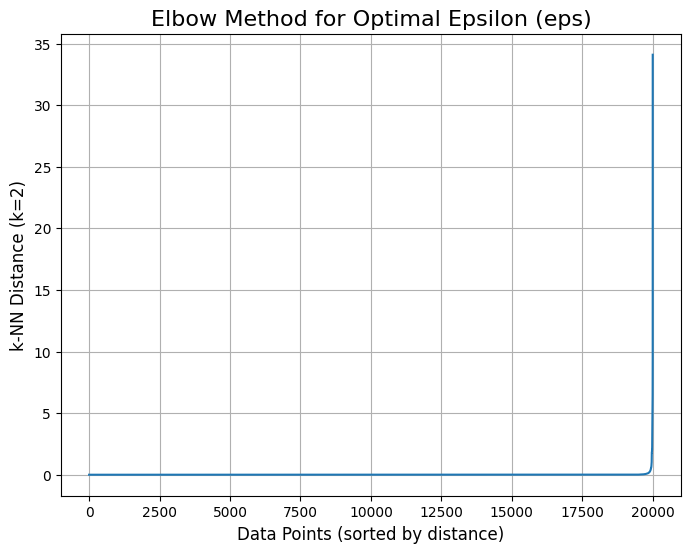

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

sample_data = data.sample(n=20000, random_state=42)

sample_data['TotalPrice'] = sample_data['Quantity'] * sample_data['UnitPrice']

features = sample_data[['Quantity', 'TotalPrice']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(scaled_features)
distances, indices = neighbors_fit.kneighbors(scaled_features)

# Sort distances to find the elbow point
distances = np.sort(distances[:, 1]) 

# Plot the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(distances)
plt.title('Elbow Method for Optimal Epsilon (eps)', fontsize=16)
plt.xlabel('Data Points (sorted by distance)', fontsize=12)
plt.ylabel('k-NN Distance (k=2)', fontsize=12)
plt.grid(True)
plt.show()


Davies-Bouldin Score: 2.2167948454791646
Silhouette Score: 0.9355945299013507
Cluster Sizes: {-1: 67, 0: 19912, 1: 8, 2: 6, 3: 7}


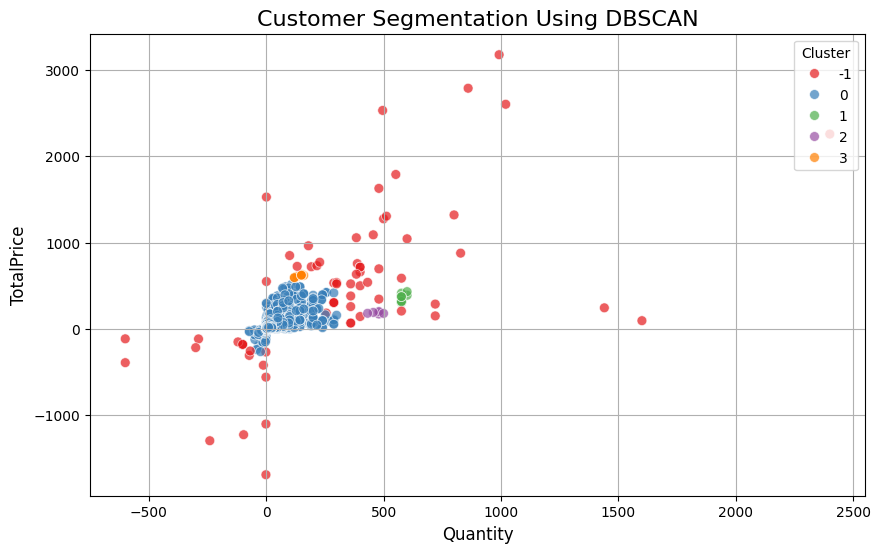

In [38]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Setup
sample_data = data.sample(n=20000, random_state=42)

sample_data['TotalPrice'] = sample_data['Quantity'] * sample_data['UnitPrice']

features = sample_data[['Quantity', 'TotalPrice']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Create and fit the DBSCAN model
dbscan = DBSCAN(eps=1.0, min_samples=5)
labels = dbscan.fit_predict(scaled_features)

# Davies-Bouldin score
db_score = davies_bouldin_score(scaled_features, labels)

# Silhouette Score
sil_score = silhouette_score(scaled_features, labels)

# Get cluster sizes
unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))

# Print the results
print(f"Davies-Bouldin Score: {db_score}")
print(f"Silhouette Score: {sil_score}")
print(f"Cluster Sizes: {cluster_sizes}")

# Add cluster labels to the data for plotting
sample_data['Cluster'] = labels

# Plot the data points with cluster labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_data, x='Quantity', y='TotalPrice', hue='Cluster', palette='Set1', s=50, alpha=0.7)

plt.title('Customer Segmentation Using DBSCAN', fontsize=16)
plt.xlabel('Quantity', fontsize=12)
plt.ylabel('TotalPrice', fontsize=12)
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)

plt.show()

DBSCAN with higher sample size.

Davies-Bouldin Score: 1.0098699312237196
Silhouette Score: 0.9500916166201683
Cluster Sizes: {-1: 154, 0: 19846}


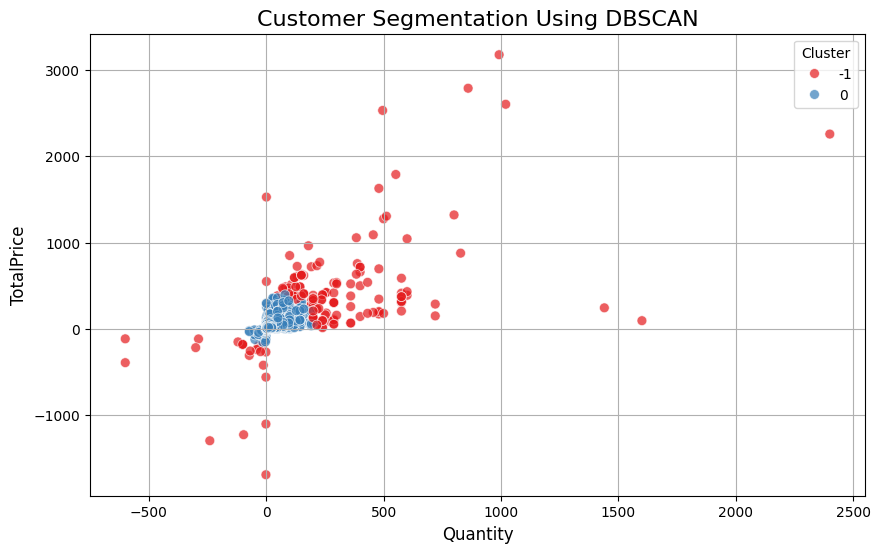

In [40]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Setup
sample_data = data.sample(n=20000, random_state=42)

sample_data['TotalPrice'] = sample_data['Quantity'] * sample_data['UnitPrice']

features = sample_data[['Quantity', 'TotalPrice']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Create and fit the DBSCAN model
dbscan = DBSCAN(eps=1.0, min_samples=15)
labels = dbscan.fit_predict(scaled_features)

# Davies-Bouldin score
db_score = davies_bouldin_score(scaled_features, labels)

# Silhouette Score
sil_score = silhouette_score(scaled_features, labels)

# Get cluster sizes
unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))

# Print the results
print(f"Davies-Bouldin Score: {db_score}")
print(f"Silhouette Score: {sil_score}")
print(f"Cluster Sizes: {cluster_sizes}")

# Add cluster labels to the data for plotting
sample_data['Cluster'] = labels

# Plot the data points with cluster labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_data, x='Quantity', y='TotalPrice', hue='Cluster', palette='Set1', s=50, alpha=0.7)

plt.title('Customer Segmentation Using DBSCAN', fontsize=16)
plt.xlabel('Quantity', fontsize=12)
plt.ylabel('TotalPrice', fontsize=12)
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)

plt.show()

HDBSCAN model

In [42]:
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 814.9/814.9 kB 4.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Davies-Bouldin Score: 0.27300789340816
Silhouette Score: 0.8739611570232756
Cluster Sizes: {-1: 250, 0: 34, 1: 19716}


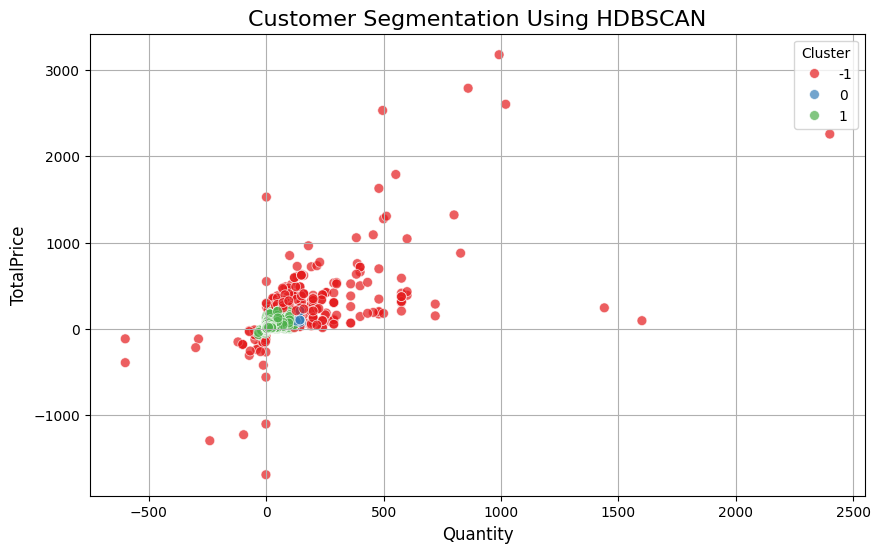

In [43]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan

# Setup
sample_data = data.sample(n=20000, random_state=42)

sample_data['TotalPrice'] = sample_data['Quantity'] * sample_data['UnitPrice']

features = sample_data[['Quantity', 'TotalPrice']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Create and fit the HDBSCAN model
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=10, cluster_selection_epsilon=1.0)
labels = hdbscan_model.fit_predict(scaled_features)

# Davies-Bouldin score
valid_labels = labels[labels != -1]
valid_scaled_features = scaled_features[labels != -1]
db_score = davies_bouldin_score(valid_scaled_features, valid_labels)

# Calculate the Silhouette Score
sil_score = silhouette_score(valid_scaled_features, valid_labels)

# Get cluster sizes
unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))

# Print the results
print(f"Davies-Bouldin Score: {db_score}")
print(f"Silhouette Score: {sil_score}")
print(f"Cluster Sizes: {cluster_sizes}")

# Add cluster labels to the data for plotting
sample_data['Cluster'] = labels

# Plot the data points with cluster labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_data, x='Quantity', y='TotalPrice', hue='Cluster', palette='Set1', s=50, alpha=0.7)

plt.title('Customer Segmentation Using HDBSCAN', fontsize=16)
plt.xlabel('Quantity', fontsize=12)
plt.ylabel('TotalPrice', fontsize=12)
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)

plt.show()


Hierarchical Models

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score


# Setup
data_sample = data.sample(n=20000, random_state=42)

customer_data = data_sample[['Quantity', 'UnitPrice']].copy()

customer_data.loc[:, 'TotalPrice'] = data_sample['Quantity'] * data_sample['UnitPrice']

scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data[['Quantity', 'TotalPrice']])

agg_clustering = AgglomerativeClustering(n_clusters=4)
customer_data['Cluster'] = agg_clustering.fit_predict(scaled_features)


# Silhouette Score
sil_score = silhouette_score(scaled_features, customer_data['Cluster'])
print(f"Silhouette Score: {sil_score}")

# Davies-Bouldin Score
db_score = davies_bouldin_score(scaled_features, customer_data['Cluster'])
print(f"Davies-Bouldin Score: {db_score}")

# Calculate the size of each cluster
unique, counts = np.unique(customer_data['Cluster'], return_counts=True)
cluster_sizes = dict(zip(unique, counts))
print(f"Cluster Sizes: {cluster_sizes}")



Silhouette Score: 0.7703296021189466
Davies-Bouldin Score: 0.8383450114061634
Cluster Sizes: {0: 16, 1: 18731, 2: 160, 3: 1093}


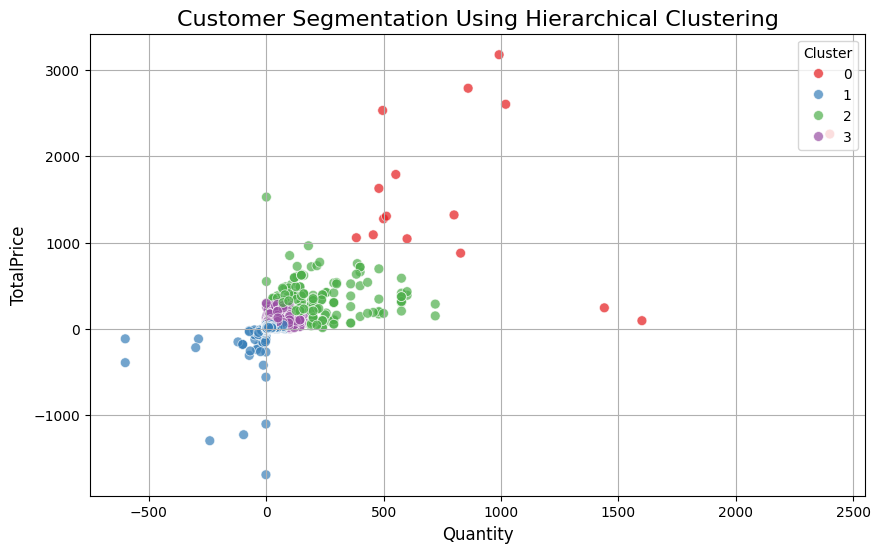

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the data points with cluster labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_data, x='Quantity', y='TotalPrice', hue='Cluster', palette='Set1', s=50, alpha=0.7)

plt.title('Customer Segmentation Using Hierarchical Clustering', fontsize=16)
plt.xlabel('Quantity', fontsize=12)
plt.ylabel('TotalPrice', fontsize=12)
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)

plt.show()


Davies-Bouldin Score: 0.774326272507967
Silhouette Score: 0.772763811729026
Cluster Sizes: {0: 160, 1: 13, 2: 18727, 3: 1093, 4: 3, 5: 4}


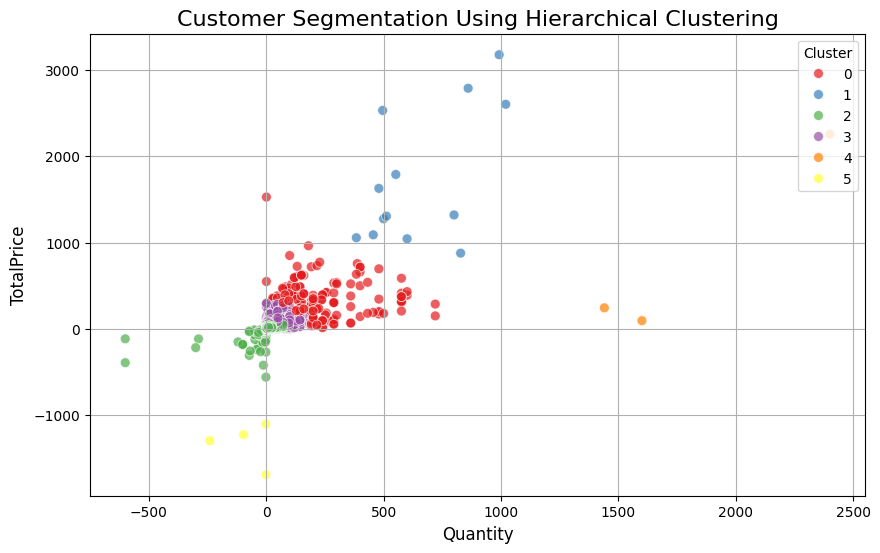

In [5]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Setup
sample_data = data.sample(n=20000, random_state=42)

sample_data['TotalPrice'] = sample_data['Quantity'] * sample_data['UnitPrice']

features = sample_data[['Quantity', 'TotalPrice']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 5: Create and fit the AgglomerativeClustering model
model = AgglomerativeClustering(linkage='ward', n_clusters=6) 
model.fit(scaled_features)

labels = model.labels_

# Add the cluster labels to the original dataframe for plotting
sample_data['Cluster'] = labels

# Calculate the Davies-Bouldin score
db_score = davies_bouldin_score(scaled_features, labels)

# Calculate the Silhouette Score
sil_score = silhouette_score(scaled_features, labels)

# Get cluster sizes
unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))

# Print the results
print(f"Davies-Bouldin Score: {db_score}")
print(f"Silhouette Score: {sil_score}")
print(f"Cluster Sizes: {cluster_sizes}")

# Plot the data points with cluster labels using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_data, x='Quantity', y='TotalPrice', hue='Cluster', palette='Set1', s=50, alpha=0.7)

plt.title('Customer Segmentation Using Hierarchical Clustering', fontsize=16)
plt.xlabel('Quantity', fontsize=12)
plt.ylabel('TotalPrice', fontsize=12)
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)

plt.show()



Davies-Bouldin Score: 0.7596234923176443
Silhouette Score: 0.9323150540942772
Cluster Sizes: {0: 19824, 1: 16, 2: 160}


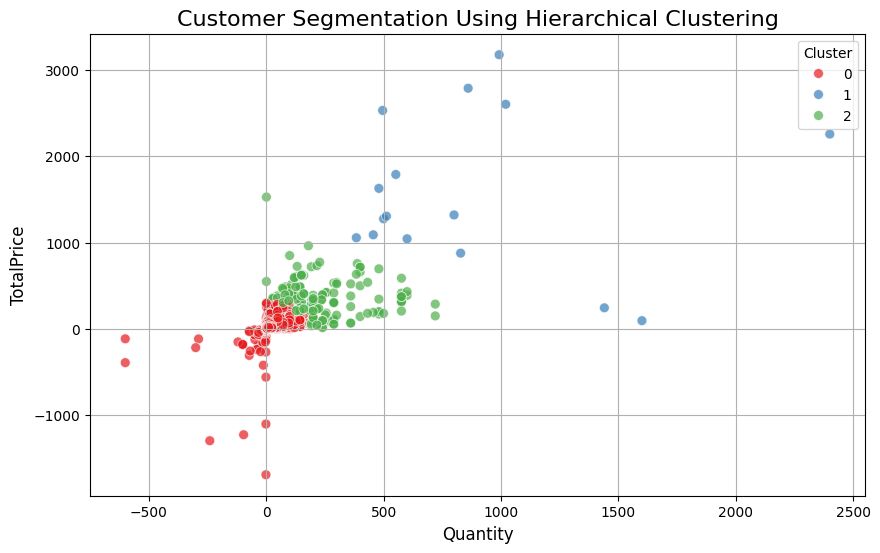

In [26]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Setup
sample_data = data.sample(n=20000, random_state=42)

sample_data['TotalPrice'] = sample_data['Quantity'] * sample_data['UnitPrice']

features = sample_data[['Quantity', 'TotalPrice']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 5: Create and fit the AgglomerativeClustering model
model = AgglomerativeClustering(linkage='ward', n_clusters=3)
model.fit(scaled_features)

labels = model.labels_

sample_data['Cluster'] = labels

# Calculate the Davies-Bouldin score
db_score = davies_bouldin_score(scaled_features, labels)

# Calculate the Silhouette Score
sil_score = silhouette_score(scaled_features, labels)

# Get cluster sizes
unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))

# Print the results
print(f"Davies-Bouldin Score: {db_score}")
print(f"Silhouette Score: {sil_score}")
print(f"Cluster Sizes: {cluster_sizes}")

# Plot the data points with cluster labels using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_data, x='Quantity', y='TotalPrice', hue='Cluster', palette='Set1', s=50, alpha=0.7)

plt.title('Customer Segmentation Using Hierarchical Clustering', fontsize=16)
plt.xlabel('Quantity', fontsize=12)
plt.ylabel('TotalPrice', fontsize=12)
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)

plt.show()


Hierarchical Clustering Complete Linkage

Davies-Bouldin Score: 1.0480667978067897
Silhouette Score: 0.4970028828684106
Cluster Sizes: {0: 3, 1: 457, 2: 14, 3: 19526}


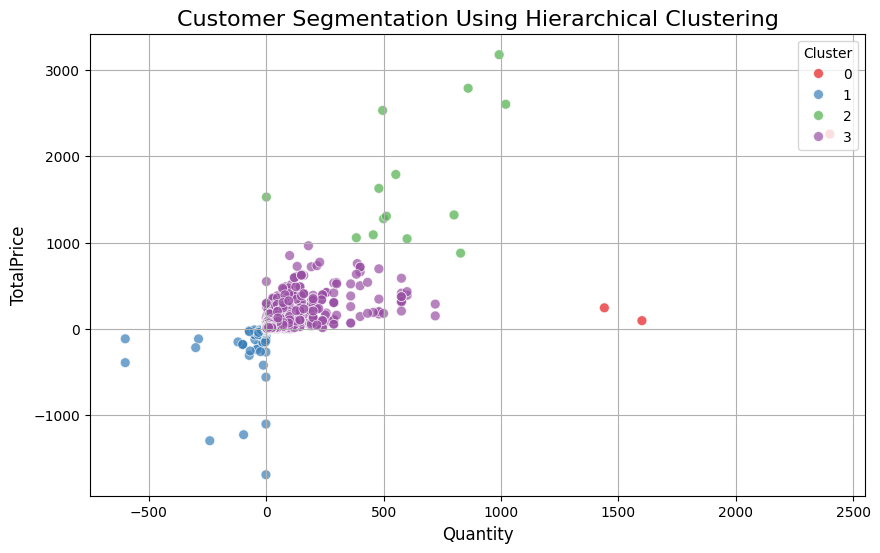

In [30]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Setup
sample_data = data.sample(n=20000, random_state=42)

sample_data['TotalPrice'] = sample_data['Quantity'] * sample_data['UnitPrice']

features = sample_data[['Quantity', 'TotalPrice']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 5: Create and fit the AgglomerativeClustering model
model = AgglomerativeClustering(linkage='complete', n_clusters=4)
model.fit(scaled_features)

labels = model.labels_

sample_data['Cluster'] = labels

# Davies-Bouldin score
db_score = davies_bouldin_score(scaled_features, labels)

# Silhouette Score
sil_score = silhouette_score(scaled_features, labels)

# Get cluster sizes
unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))

# Print the results
print(f"Davies-Bouldin Score: {db_score}")
print(f"Silhouette Score: {sil_score}")
print(f"Cluster Sizes: {cluster_sizes}")

# Plot the data points with cluster labels using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_data, x='Quantity', y='TotalPrice', hue='Cluster', palette='Set1', s=50, alpha=0.7)

plt.title('Customer Segmentation Using Hierarchical Clustering', fontsize=16)
plt.xlabel('Quantity', fontsize=12)
plt.ylabel('TotalPrice', fontsize=12)
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)

plt.show()


LIME analysis for Hierarchical clustering model with 3 clusters,

In [44]:
!pip install lime



[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [45]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

# Load model
sample_data = data.sample(n=20000, random_state=42)

sample_data['TotalPrice'] = sample_data['Quantity'] * sample_data['UnitPrice']

features = sample_data[['Quantity', 'TotalPrice']]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

model = AgglomerativeClustering(linkage='ward', n_clusters=3)
labels = model.fit_predict(scaled_features)
sample_data['Cluster'] = labels

# Define a function to mimic a supervised model
# Returns distances of a data point to cluster centroids
def clustering_model(data):
    # Calculate mean of each cluster
    centroids = np.array([scaled_features[labels == i].mean(axis=0) for i in np.unique(labels)])
    # Compute distances from data points to centroids
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    return distances

# Initialize LIME explainer
explainer = LimeTabularExplainer(
    scaled_features,
    feature_names=features.columns,
    class_names=[f'Cluster {i}' for i in range(3)],  
    discretize_continuous=True
)

# Choose a random data point and explain its cluster
index = 42 
explanation = explainer.explain_instance(
    scaled_features[index],
    clustering_model,
    num_features=2
)

# Visualize the explanation
explanation.show_in_notebook()


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/lime/lime_tabular.py:372: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  warnings.warn("""


ChatGPT Citations

Prompt: How would you implement a DBSCAN model. What would be the code to do so?
Output:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Subsample 10,000 rows
sample_data = data.sample(n=20000, random_state=42)

# Step 2: Calculate TotalPrice (Quantity * UnitPrice)
sample_data['TotalPrice'] = sample_data['Quantity'] * sample_data['UnitPrice']

# Step 3: Select relevant features (e.g., 'Quantity' and 'TotalPrice')
features = sample_data[['Quantity', 'TotalPrice']]

# Step 4: Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 5: Create and fit the DBSCAN model
dbscan = DBSCAN(eps=1.0, min_samples=5)
labels = dbscan.fit_predict(scaled_features)

# Step 6: Calculate the Davies-Bouldin score
db_score = davies_bouldin_score(scaled_features, labels)

# Step 7: Calculate the Silhouette Score
sil_score = silhouette_score(scaled_features, labels)

# Step 8: Get cluster sizes
unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))

# Step 9: Print the results
print(f"Davies-Bouldin Score: {db_score}")
print(f"Silhouette Score: {sil_score}")
print(f"Cluster Sizes: {cluster_sizes}")

# Step 10: Add cluster labels to the data for plotting
sample_data['Cluster'] = labels

# Step 11: Plot the data points with cluster labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=sample_data, x='Quantity', y='TotalPrice', hue='Cluster', palette='Set1', s=50, alpha=0.7)

# Step 12: Customize the plot
plt.title('Customer Segmentation Using DBSCAN', fontsize=16)
plt.xlabel('Quantity', fontsize=12)
plt.ylabel('TotalPrice', fontsize=12)
plt.legend(title='Cluster', loc='upper right')
plt.grid(True)

# Step 13: Show the plot
plt.show()

Prompt: How would I implement a Hierarchical Clustering algorithm, what would the code look like?
Output:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score


# Step 2: Sample the data to reduce size
data_sample = data.sample(n=20000, random_state=42)  # Adjust n to sample more or fewer rows

# Step 3: Create customer_data with relevant columns
customer_data = data_sample[['Quantity', 'UnitPrice']].copy()  # Use .copy() to avoid warnings

# If TotalPrice needs to be calculated:
customer_data.loc[:, 'TotalPrice'] = data_sample['Quantity'] * data_sample['UnitPrice']

# Step 4: Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data[['Quantity', 'TotalPrice']])

# Step 5: Apply Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=4)  # Specify the number of clusters
customer_data['Cluster'] = agg_clustering.fit_predict(scaled_features)

# Step 6: Evaluate clustering performance

# Calculate Silhouette Score
sil_score = silhouette_score(scaled_features, customer_data['Cluster'])
print(f"Silhouette Score: {sil_score}")

# Calculate Davies-Bouldin Score
db_score = davies_bouldin_score(scaled_features, customer_data['Cluster'])
print(f"Davies-Bouldin Score: {db_score}")

# Calculate the size of each cluster
unique, counts = np.unique(customer_data['Cluster'], return_counts=True)
cluster_sizes = dict(zip(unique, counts))
print(f"Cluster Sizes: {cluster_sizes}")

Prompt: How would I use LIME to analyze this model, what would the code look like?
Output:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

# Step 1: Subsample 20,000 rows
sample_data = data.sample(n=20000, random_state=42)

# Step 2: Calculate TotalPrice (Quantity * UnitPrice)
sample_data['TotalPrice'] = sample_data['Quantity'] * sample_data['UnitPrice']

# Step 3: Select relevant features (e.g., 'Quantity' and 'TotalPrice')
features = sample_data[['Quantity', 'TotalPrice']]

# Step 4: Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 5: Create and fit the AgglomerativeClustering model
model = AgglomerativeClustering(linkage='ward', n_clusters=3)  # Adjust n_clusters if needed
labels = model.fit_predict(scaled_features)
sample_data['Cluster'] = labels

# Step 6: Define a function to mimic a supervised model
# Returns distances of a data point to cluster centroids
def clustering_model(data):
    # Calculate mean of each cluster
    centroids = np.array([scaled_features[labels == i].mean(axis=0) for i in np.unique(labels)])
    # Compute distances from data points to centroids
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    return distances

# Step 7: Initialize LIME explainer
explainer = LimeTabularExplainer(
    scaled_features,
    feature_names=features.columns,
    class_names=[f'Cluster {i}' for i in range(3)],  # Rename clusters
    discretize_continuous=True
)

# Step 8: Choose a random data point and explain its cluster
index = 42  # Example data point
explanation = explainer.explain_instance(
    scaled_features[index],
    clustering_model,
    num_features=2
)

# Step 9: Visualize the explanation
explanation.show_in_notebook()